<a href="https://colab.research.google.com/github/AdityaStark7/Nasa_Asteroids_Classification/blob/main/NASA_Asteroids_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

SEED = 7

In [2]:
df = pd.read_csv('/content/nasa.csv', parse_dates=['Close Approach Date', 'Orbit Determination Date', 'Epoch Date Close Approach'])
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


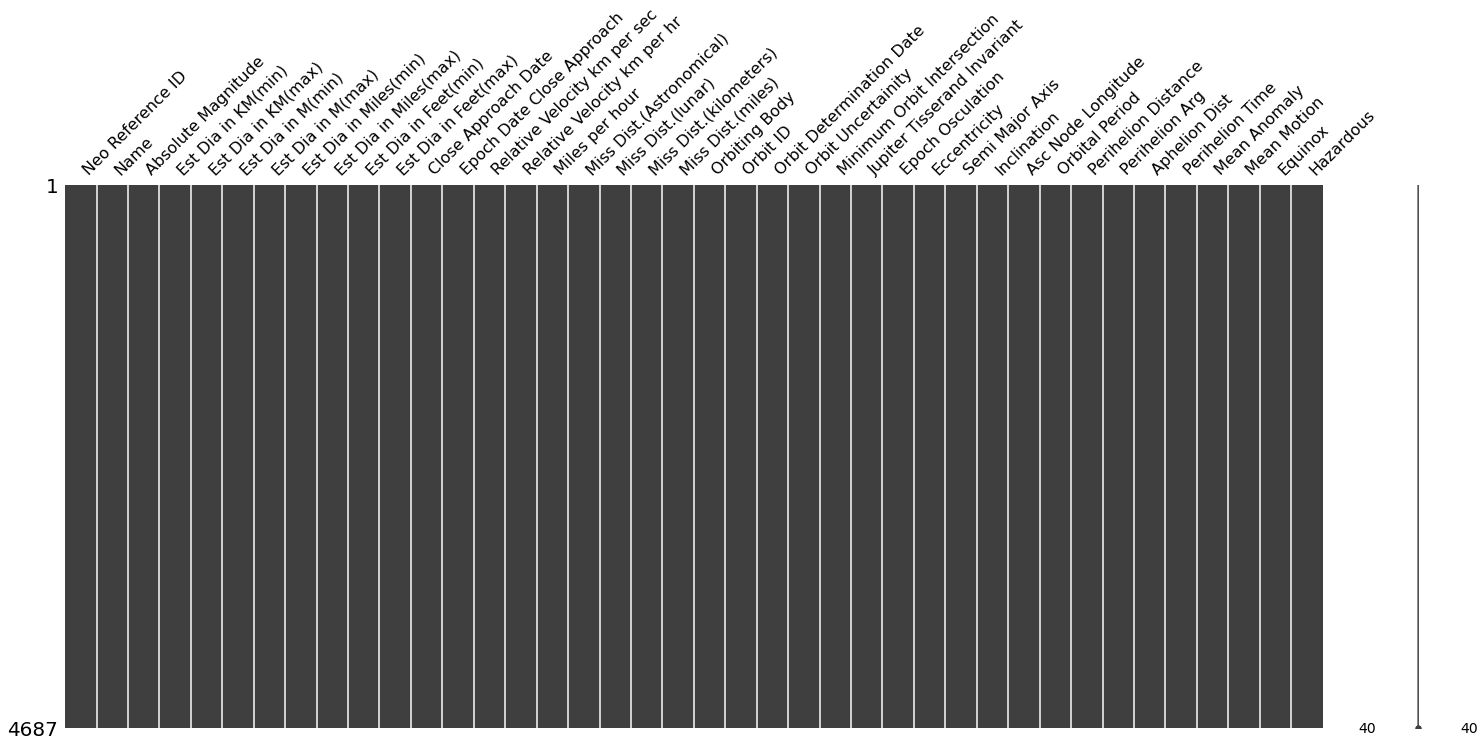

In [3]:
import missingno as msno

msno.matrix(df)

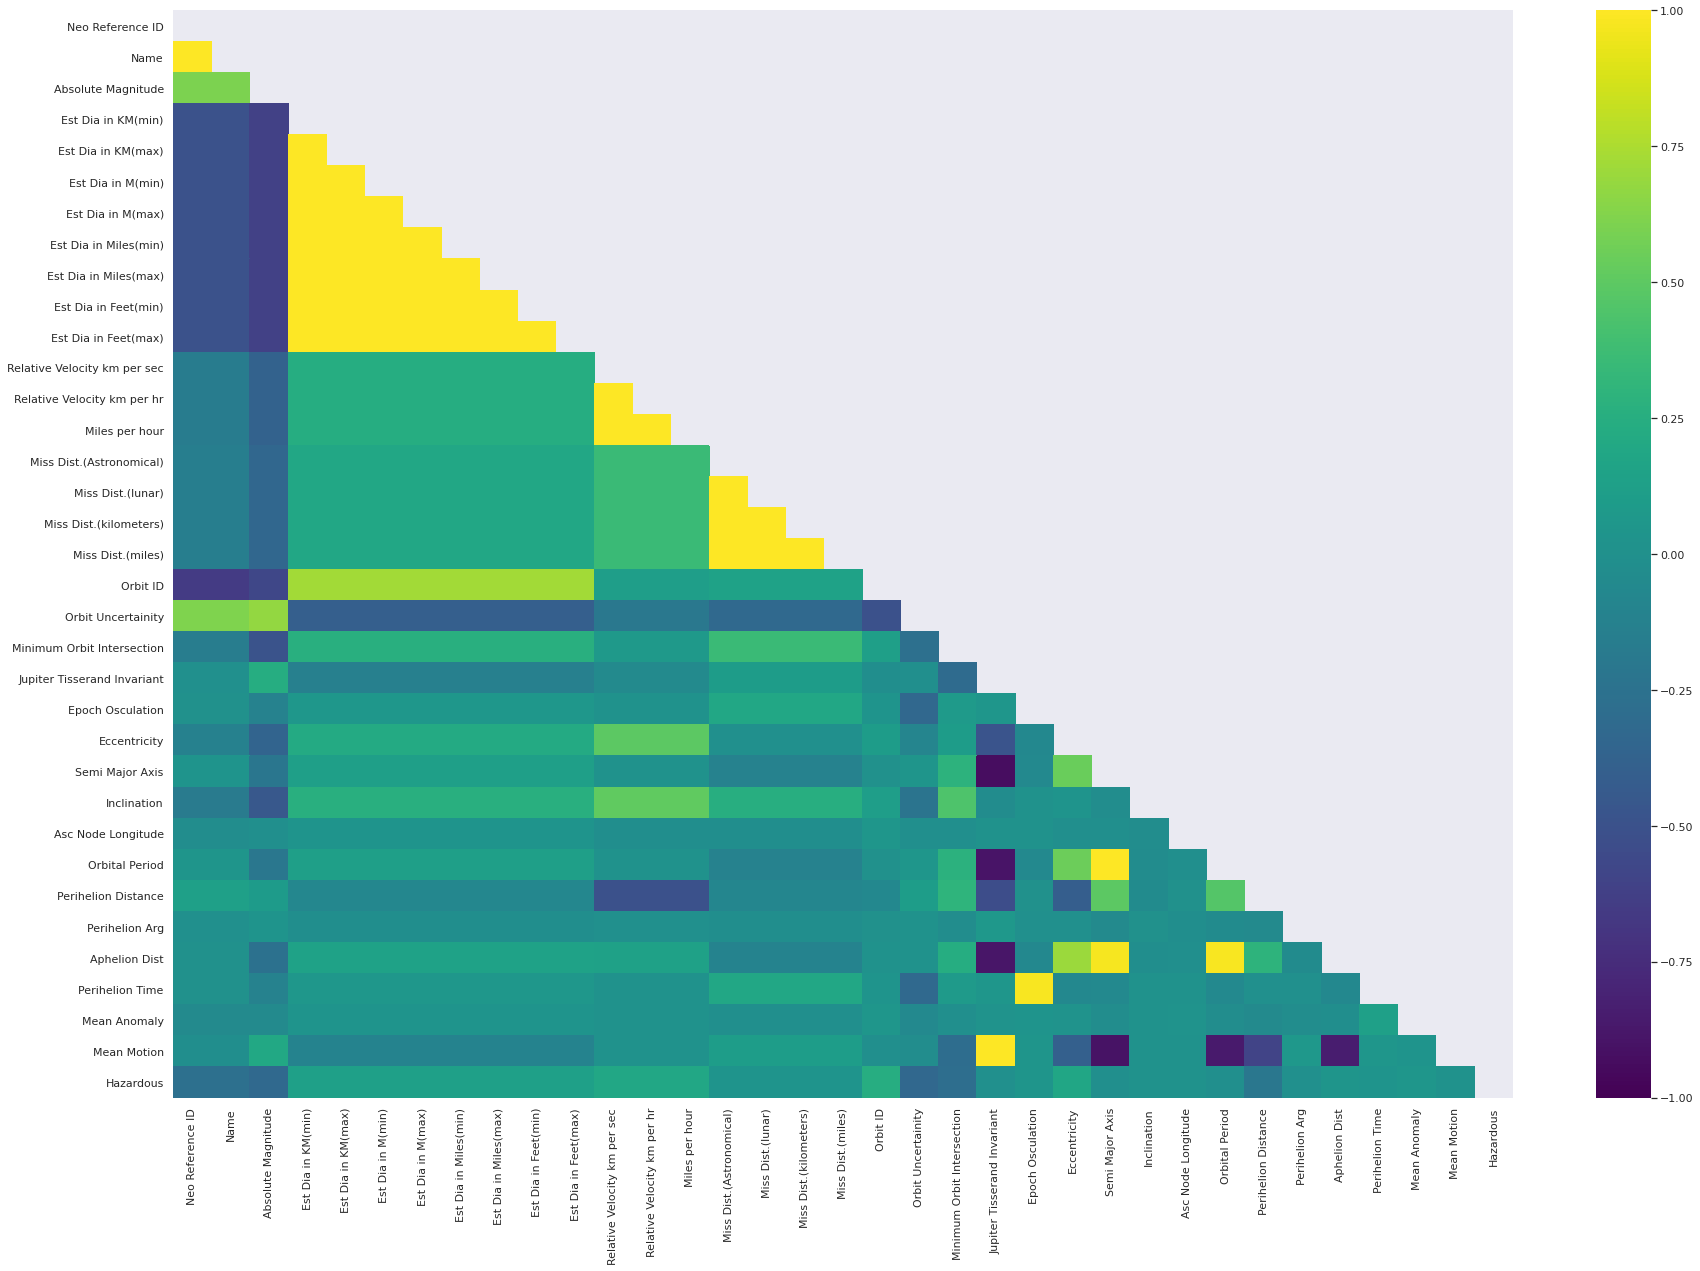

In [4]:
sns.set(rc={'figure.figsize':(30,20)})

mask = np.triu(df.corr())

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="viridis", mask = mask)
plt.show()
plt.close()

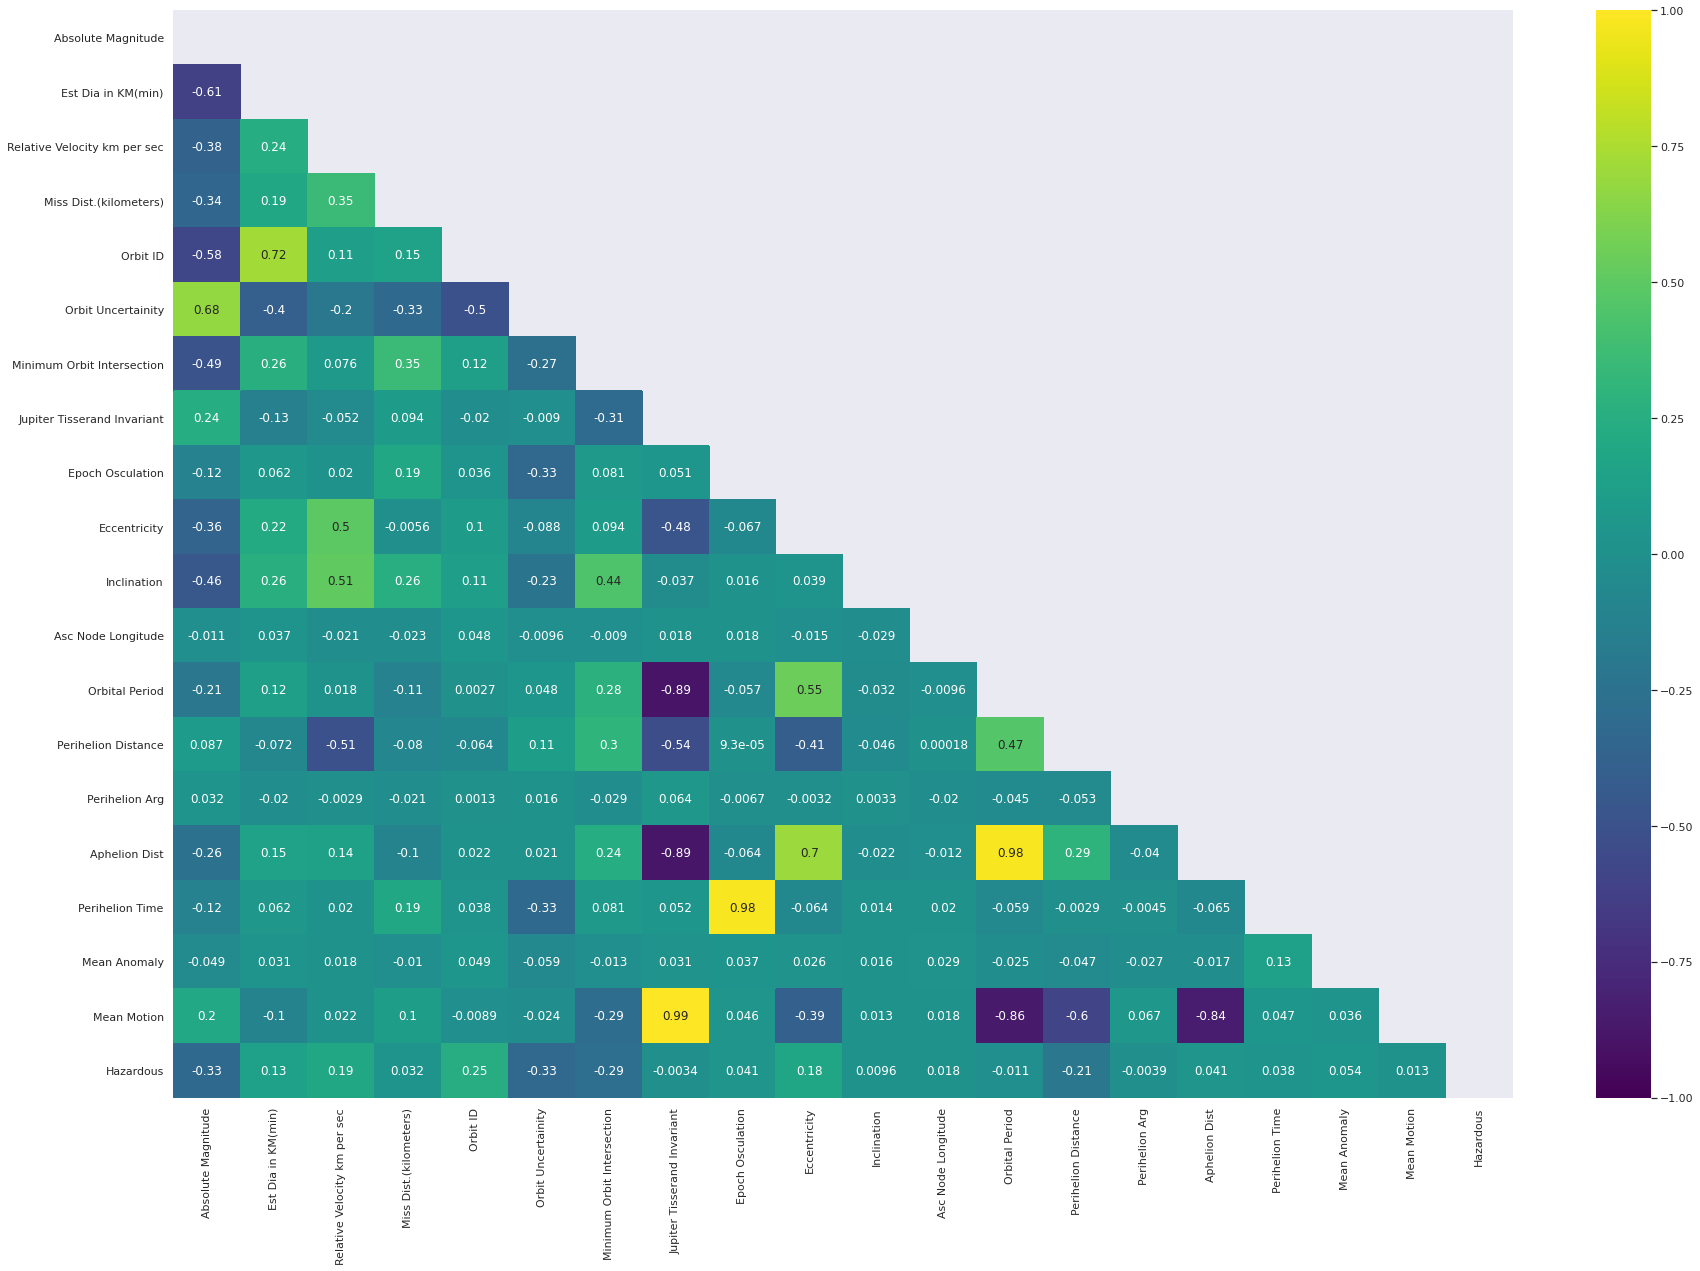

In [5]:
df = df.drop(['Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)',
              'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)',
              'Est Dia in KM(max)',
              'Relative Velocity km per hr', 'Miles per hour',
              'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(miles)',
              'Semi Major Axis',
              'Neo Reference ID', 'Name',
              'Close Approach Date', 'Epoch Date Close Approach',
              'Orbit Determination Date']
             ,axis=1
          )


mask = np.triu(df.corr())

sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="viridis", mask = mask, annot=True)
plt.show()
plt.close()

Dropping Some of the features as they have same and repeated obs.

In [6]:
encoder = LabelEncoder()

df['hazardous'] = encoder.fit_transform(df.Hazardous)

df = df.drop(['Orbiting Body', 'Equinox', 'Hazardous'], axis = 1)

In [7]:
features = df.drop('hazardous', axis = 1).values
target = df['hazardous'].values

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size = 0.7,
                                                    stratify = target,
                                                    random_state = SEED
                                                  )

In [8]:
features = df.drop('hazardous', axis=1).values
label = df.hazardous.values


training_features, test_features, training_label, test_label = train_test_split(features, label,
                                                                                test_size=0.8,
                                                                                stratify=label,
                                                                                random_state=SEED)

df_graph = df.copy()
feature_names = df_graph.drop('hazardous', axis=1).columns.tolist()

In [10]:
xgb_params = {'max_depth': np.arange(0, 5, 1),
              'objective': ['binary:logistic'],
              'random_state': [SEED],
              'alpha': [0, 0.01, 0.1, 1],
              'lambda': [0, 0.01, 0.1, 1],
              'subsample': [0.25, 0.5, 0.75],
              'colsample_bytree': [0.25, 0.5, 0.75],
              'eval_metric': ['logloss'],
              'learning_rate': [0.03, 0.04, 0.05, 0.06]
              }


xgb_grid = GridSearchCV(estimator=XGBClassifier(), param_grid=xgb_params,
                            scoring='accuracy', cv=5)
xgb_grid.fit(X_train, y_train)
xgb_opt_param = xgb_grid.best_params_
xgb_best_score = (xgb_grid.best_score_*100).round(2)
xgb_best_est = xgb_grid.best_estimator_
xgb_feat_imp = xgb_best_est.feature_importances_

xgb_holdout_score = (xgb_grid.score(X_test, y_test)*100).round(2)

print('Optimal Hyperparameters:')
print(xgb_opt_param)
print('Optimal Estimator:')
print(xgb_best_est)
print('\n')
print('Training Accuracy {}'.format(xgb_best_score))
print('Testing Accuracy {}'.format(xgb_holdout_score))

Optimal Hyperparameters:
{'alpha': 0, 'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'lambda': 0, 'learning_rate': 0.03, 'max_depth': 3, 'objective': 'binary:logistic', 'random_state': 7, 'subsample': 0.75}
Optimal Estimator:
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0, lambda=0, learning_rate=0.03, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.75, verbosity=1)


Training Accuracy 99.5
Testing Accuracy 99.48
